##  **Capstone Project for Advanced Data Science with IBM**



## Zaw Min Thant, Ph.D.




#**1. Introduction**

**Business issues**

Heart failure is a life-threatening issue in our society and higher negative impacts on our social and business. When someone encounters heart failure, the heart cannot pump enough blood to the body to support essential physiological processes. A clear understanding of which factors cause heart failure will enhance the survival chance of patients in the future.


**Use case**

We will use a real-world data of heart failure clinical records from **UC Irvine Machine Learning Repository**. This dataset derived from *Chicco and Jurman (2020)*. The dataset includes cases of 299 patients, and it was collected in 2015.


**Objectives**

- to explore which machine learning algorithms are better suited to predict the event of deceased from heart failure
- to predict the probability of deceased from heart failure and which factors most affect on heart failure



**Methodology**

The target variable (DEATH_EVENT) includes binary classification (Survived:0 & Deceased:1). We will demostrate four Machine Learning classifiers (***Logistic Regression, Random Forest, Gradient-Boosted Tree, and Feedforward Neutral Network***), to find out which one is better to predict the outcomes.

PySpark version 3.3.0 and Python 3.10 Jupyter Notebook on Watson Studio will be used for this analysis. PySpark is a powerful tool to analyze big data because Python Jupyter Notebook on local machines has limitations to handle big data. It is also flexible to use it on IBM Cloud (IBM Watson Studio) and other cloud-based platforms.
Although this dataset is not big data (only 299 observations), PySpark will be used for this Capstone project.


Firstly, we will install Pyspark version 3.3.0. Please note that it is better to install the updated version.

In [1]:
!pip install pyspark==3.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 7.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 53.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764025 sha256=1a3b82f1f1c603e6d63a78af0bb02e36e464b89e14c2b15c4e989d2871163d6a
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/81/9c/6c/d5200fcf351ffa39cbe09911e99703283624cd037df58070d9
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


Tensorflow will be installed for Deep Learning - Neutral Networks. It is important to install compatible Keras version with Tensorflow version.

In [4]:
!pip install tensorflow==2.11.0rc0

Keras will also be installed for Deep Learning - Neutral Networks.

In [5]:
!pip install keras==2.10.0rc1

In [7]:
## Loading required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

In [8]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [10]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

#**2. Getting Data (Extract, Transform, Load - ETL)**

We will download dataset from **UC Irvine Machine Learning Repository** for Heart Failure Clinical Records. This dataset was zipped and it is needed to unzip.

In [11]:
!wget -O heart+failure+clinical+records.zip http://archive.ics.uci.edu/static/public/519/heart+failure+clinical+records.zip
print('unziping ...')
!unzip -o -j heart+failure+clinical+records.zip

--2023-08-05 20:50:13--  http://archive.ics.uci.edu/static/public/519/heart+failure+clinical+records.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘heart+failure+clinical+records.zip’

heart+failure+clini     [ <=>                ]  12.13K  --.-KB/s    in 0.001s  

2023-08-05 20:50:13 (9.87 MB/s) - ‘heart+failure+clinical+records.zip’ saved [12421]

unziping ...
Archive:  heart+failure+clinical+records.zip
 extracting: heart_failure_clinical_records_dataset.csv  


#**3. Exploratory Data Analysis (EDA)**

Firstly, we will load csv file to check data quality with visualization.

In [12]:
dat = pd.read_csv("heart_failure_clinical_records_dataset.csv", encoding='ISO-8859-1')
dat.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Checking the rows and columns of the data. Our dataset includes 299 rows and 13 features. It means that this dataset is not large.

In [13]:
dat.shape

(299, 13)

Checking the missing values in the data.

In [14]:
dat.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

*The dataset includes no missing values, which is good.*

..........................

Let's check the type of the data.

In [15]:
dat.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

Let's visualize each feature (excluding the target feature) to look at the disribution of data.

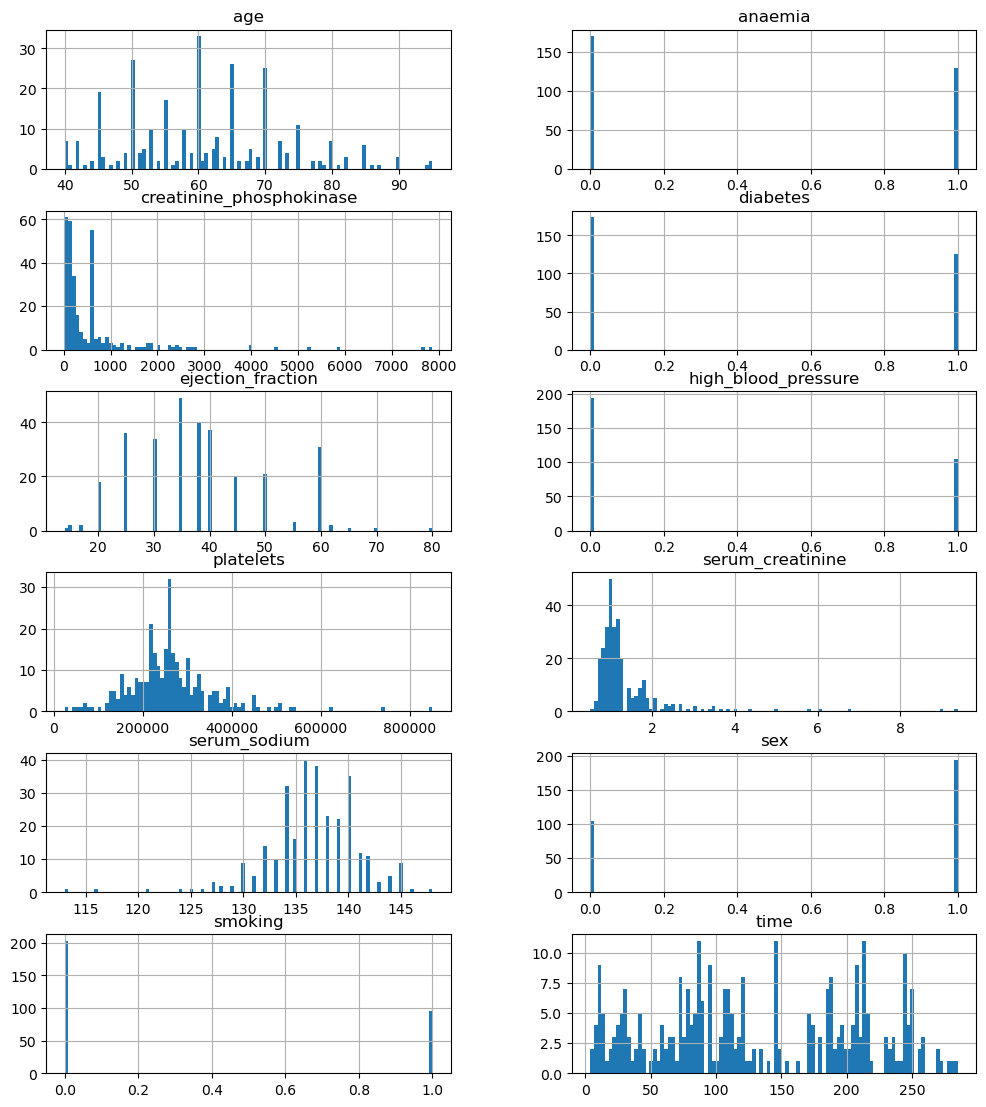

In [16]:
columns = list(dat)[0:12] # Excluding Target column which has only Survived/Deceased (0,1)
dat[columns].hist(stacked=False, bins=100, figsize=(12,30), layout=(13,2));

Now, it can be seen that five features are Binary classification (0/1) (Yes/No or Male/Female), which are 'anemia', 'diabetes', 'high_blood_pressure', 'sex', and 'smoking'.

.................................................

Then, let's visualize the target: 'DEATH_EVENT'.

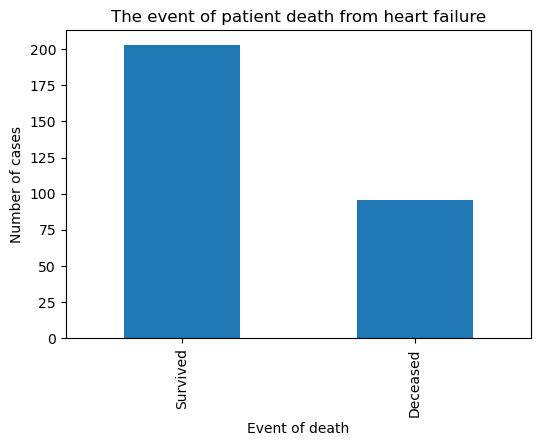

In [17]:
nc = {0: 'Survived', 1: 'Deceased'} #rename the target binary value (0/1) to string (words) for visualization purpose

dat['DEATH_EVENT'].value_counts().rename(nc).plot(kind='bar', figsize=(6,4))
plt.title('The event of patient death from heart failure')
plt.xlabel('Event of death')
plt.ylabel('Number of cases')
plt.show()

We will convert (Binary) numerical columns to categorical columns to exclude when checking correlation.

In [18]:
for col in ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']:
    dat[col] = dat[col].astype('category')

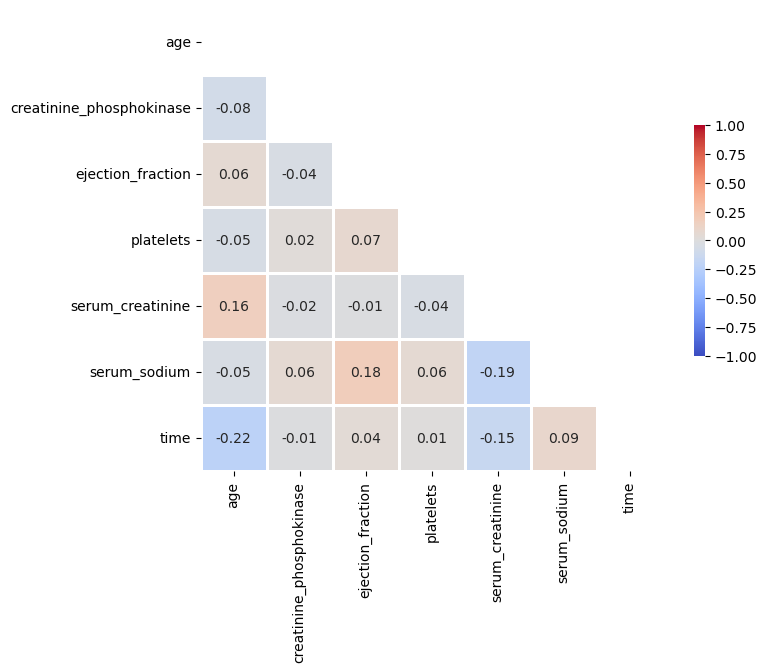

In [19]:
corr = dat.drop('DEATH_EVENT', axis = 1).corr()
plt.figure(figsize=(8, 6))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap="coolwarm",
            annot=True,
            fmt=".2f",
            mask=mask,
            vmax=1,
            vmin=-1,
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": .5})
plt.show()

It is found that the correlation between pair of numerical features is not strong, indicating that it is very good for further modelling.

........................

Looking at the pairwise distribution of data.

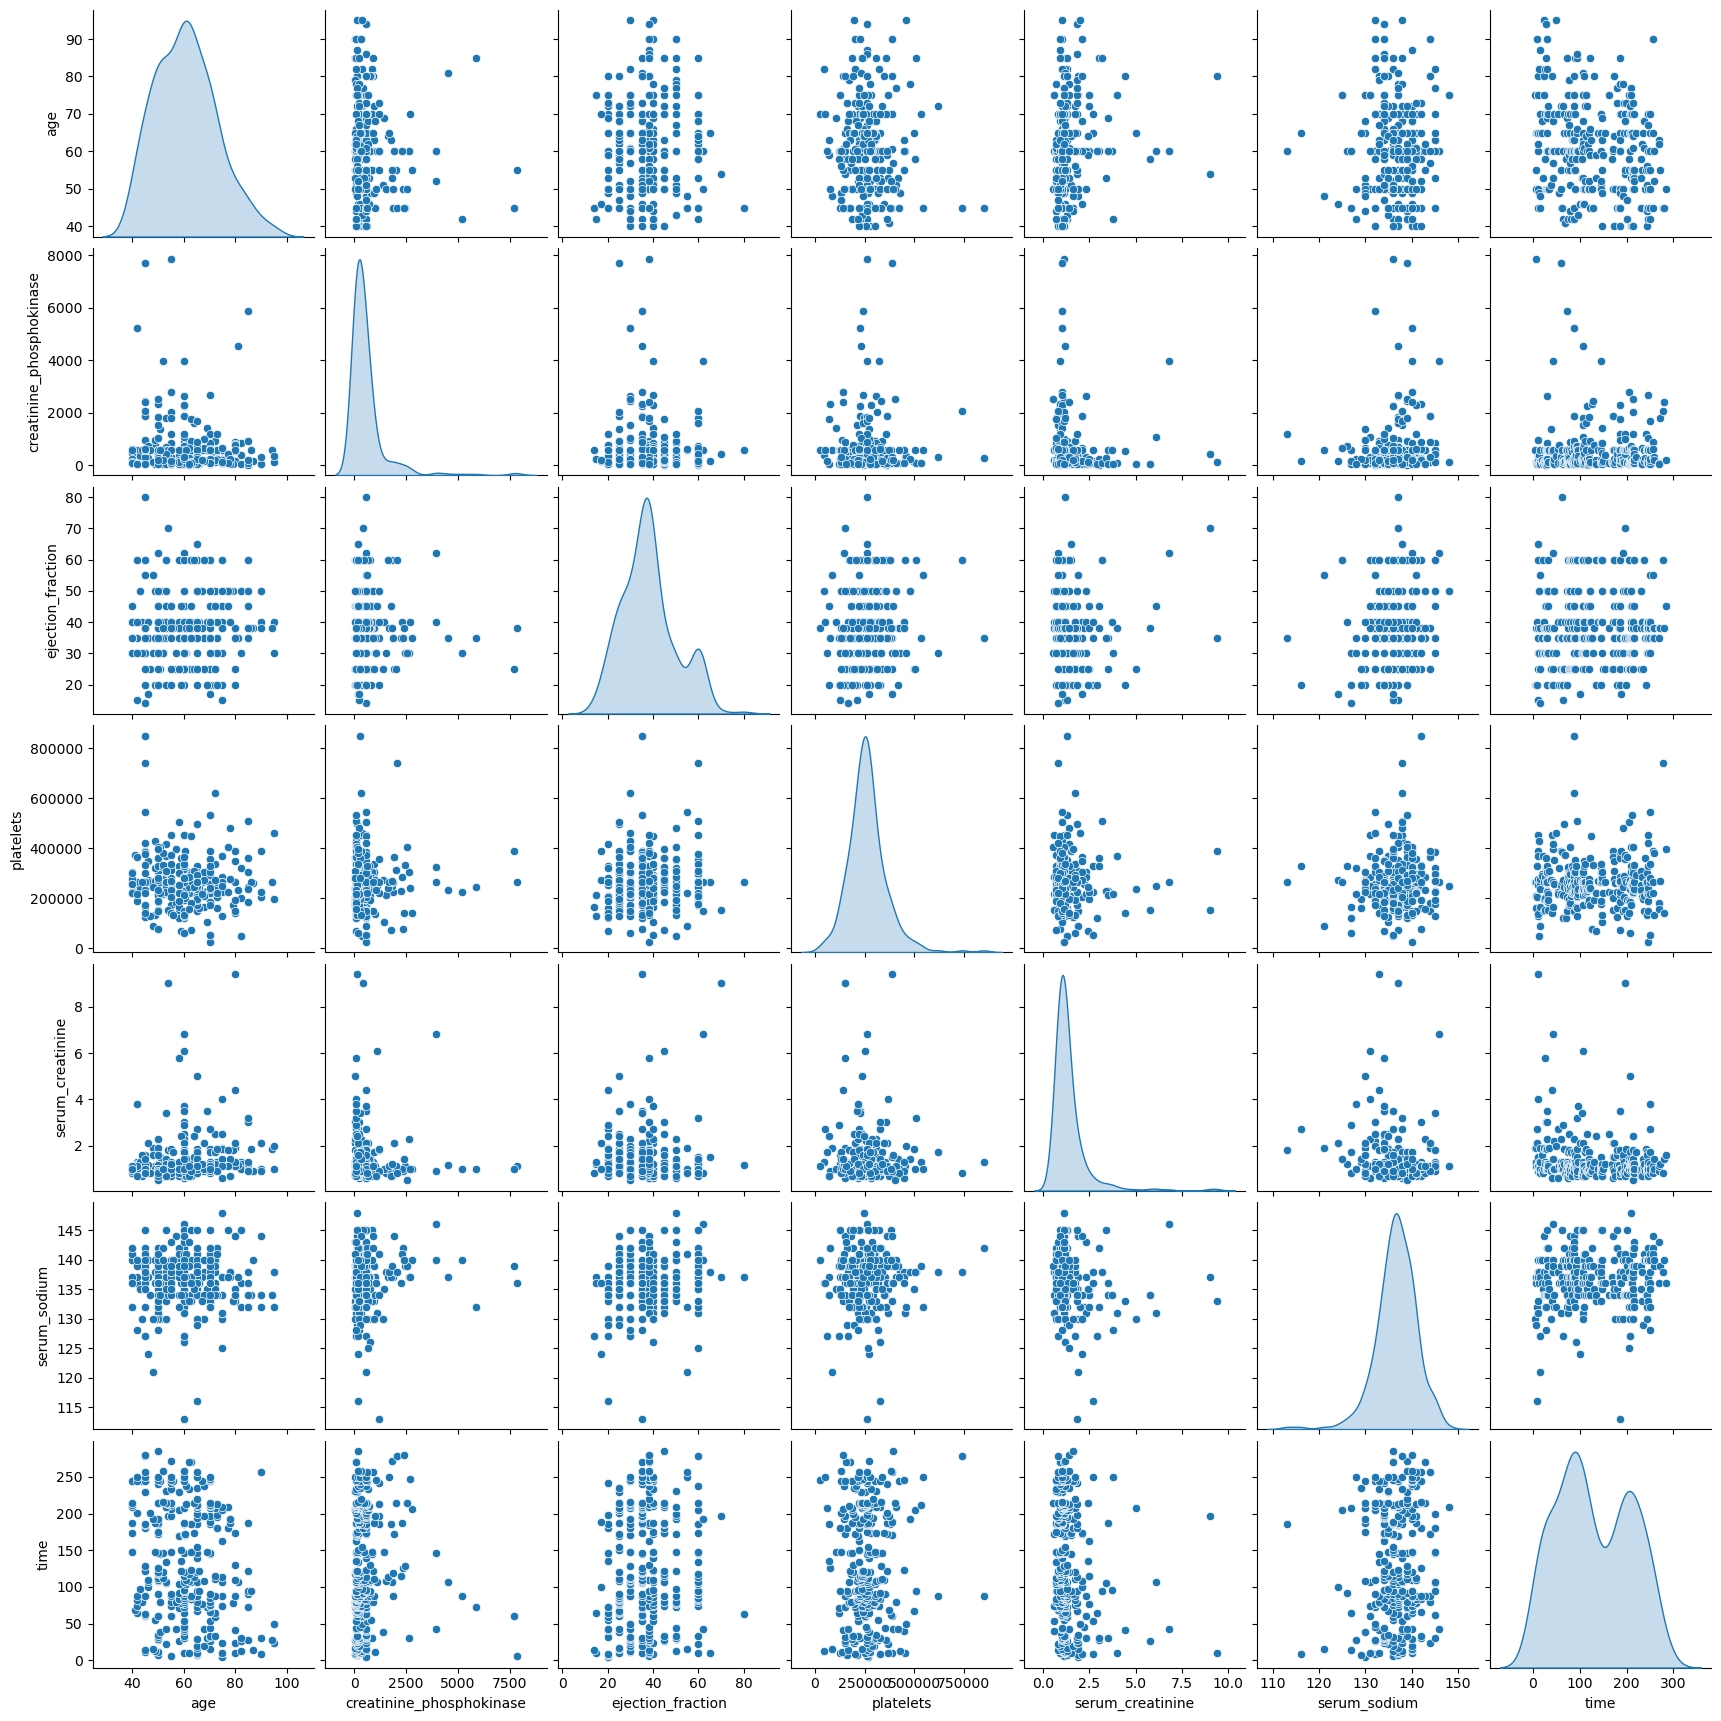

In [20]:
dat1 = dat.drop('DEATH_EVENT', axis = 1)
sns.pairplot(dat1, diag_kind ='kde')

As you can see pairwise distribution of input features, there are weak correlations between variables, indicating that it is good for further modeling.

.................................

Now, we will create a Spark session for Machine Learning and read data files using Spark through PySpark.

In [22]:
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('heart+failure+clinical+records.zip').getOrCreate()
datt = spark.read.csv('heart_failure_clinical_records_dataset.csv', header = True, inferSchema = True)
datt.printSchema()

root
 |-- age: double (nullable = true)
 |-- anaemia: integer (nullable = true)
 |-- creatinine_phosphokinase: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- ejection_fraction: integer (nullable = true)
 |-- high_blood_pressure: integer (nullable = true)
 |-- platelets: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- serum_sodium: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- smoking: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- DEATH_EVENT: integer (nullable = true)



In [23]:
datt.show(10)

+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
| age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|75.0|      0|                     582|       0|               20|                  1| 265000.0|             1.9|         130|  1|      0|   4|          1|
|55.0|      0|                    7861|       0|               38|                  0|263358.03|             1.1|         136|  1|      0|   6|          1|
|65.0|      0|                     146|       0|               20|                  0| 162000.0|             1.3|         129|  1|      1|   7|          1|
|50.0|      1|                     111|       0|               2

In [24]:
datt.groupBy('DEATH_EVENT').count().show() ## checking the distribution of the target

+-----------+-----+
|DEATH_EVENT|count|
+-----------+-----+
|          1|   96|
|          0|  203|
+-----------+-----+



#**4. Feature Creation and Engineering**

This dataset has no missing value, which is good and we do not need to do "Imputing".

We will not create new features for this analysis.

The categorical integer features will be transformed into 'one-hot' vectors using 'One-hot-encoding'.

Under Feature engineering, we will transform input features into a single vector feature by using PySpark's VectorAssembler. In our project, we have 12 independent variables (features) and one dependent variable (label). We will transform 12 columns into one feature column in the list form.

In [25]:
from pyspark.ml.feature import OneHotEncoder

# Create one hot encoders for the categorical features
encoder1 = OneHotEncoder(inputCol = 'anaemia', outputCol = 'anaemiaVec')
encoder2 = OneHotEncoder(inputCol = 'diabetes', outputCol = 'diabetesVec')
encoder3 = OneHotEncoder(inputCol = 'high_blood_pressure', outputCol = 'high_blood_pressureVec')
encoder4 = OneHotEncoder(inputCol = 'sex', outputCol = 'sexVec')
encoder5 = OneHotEncoder(inputCol = 'smoking', outputCol = 'smokingVec')

Now, we will combine created features into respected features and then normalize them.

In [26]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

# Create a features vector

colms = ['anaemiaVec', 'diabetesVec', 'high_blood_pressureVec', 'sexVec', 'smokingVec',
                                               'age', 'creatinine_phosphokinase', 'ejection_fraction',
                                               'platelets', 'serum_creatinine', 'serum_sodium', 'time']
vectorAssembler = VectorAssembler(inputCols = colms,
                                  outputCol = 'featuresVec')

# Normalize the features data
normalizer = MinMaxScaler(inputCol = 'featuresVec', outputCol = 'features')

Let's create a Machine Learning Pipeline from the created feature engineering.

In [27]:
from pyspark.ml import Pipeline

# Create a Feature Engineering ML pipeline
pipeline = Pipeline(stages = [encoder1, encoder2, encoder3, encoder4, encoder5, vectorAssembler, normalizer])
datt_normalized_data = pipeline.fit(datt).transform(datt)
datt_normalized_data.show(10)

+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+-------------+-------------+----------------------+-------------+-------------+--------------------+--------------------+
| age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|   anaemiaVec|  diabetesVec|high_blood_pressureVec|       sexVec|   smokingVec|         featuresVec|            features|
+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+-------------+-------------+----------------------+-------------+-------------+--------------------+--------------------+
|75.0|      0|                     582|       0|               20|                  1| 265000.0|             1.9|         130|  1|      0|   4|          1|(1,[0],[1.0])|

We need to make data only containing the normalized features vector by removing unnecessay features, but it is needed to retain the target (DEATH_EVENT).

In [28]:
datt_normalized_data = datt_normalized_data.drop('age').drop('anaemia').drop('creatinine_phosphokinase').drop('diabetes')\
                        .drop('ejection_fraction').drop('high_blood_pressure').drop('platelets') \
                        .drop('serum_creatinine').drop('serum_sodium').drop('sex').drop('smoking') \
                        .drop('time').drop('anaemiaVec').drop('diabetesVec').drop('high_blood_pressureVec') \
                        .drop('sexVec').drop('smokingVec').drop('featuresVec')

In [29]:
datt_normalized_data.show(10)

+-----------+--------------------+
|DEATH_EVENT|            features|
+-----------+--------------------+
|          1|[1.0,1.0,0.0,0.0,...|
|          1|[1.0,1.0,1.0,0.0,...|
|          1|[1.0,1.0,1.0,0.0,...|
|          1|[0.0,1.0,1.0,0.0,...|
|          1|[0.0,0.0,1.0,1.0,...|
|          1|[0.0,1.0,0.0,0.0,...|
|          1|[0.0,1.0,1.0,0.0,...|
|          1|[0.0,0.0,1.0,0.0,...|
|          1|[1.0,1.0,1.0,1.0,...|
|          1|[0.0,1.0,0.0,0.0,...|
+-----------+--------------------+
only showing top 10 rows



We will rename the target column as label.

In [30]:
dtt = datt_normalized_data.withColumnRenamed('DEATH_EVENT', 'label')
dtt.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[1.0,1.0,0.0,0.0,...|
|    1|[1.0,1.0,1.0,0.0,...|
|    1|[1.0,1.0,1.0,0.0,...|
|    1|[0.0,1.0,1.0,0.0,...|
|    1|[0.0,0.0,1.0,1.0,...|
|    1|[0.0,1.0,0.0,0.0,...|
|    1|[0.0,1.0,1.0,0.0,...|
|    1|[0.0,0.0,1.0,0.0,...|
|    1|[1.0,1.0,1.0,1.0,...|
|    1|[0.0,1.0,0.0,0.0,...|
+-----+--------------------+
only showing top 10 rows



Let's split the data for train and test with 80% training and 20% test.

In [31]:
dt_train, dt_test = dtt.randomSplit([0.8, 0.2])

#**5**. **Model Definition, Training, and Evaluation the performance of Machine Learning and Deep Learning Algorithms**

**Model Definition**

The data include labeled features and it is the best suited to use Supervised Machine Learning algorithms. In Supervised Machine Learning, there are two learning algorithms: Regression and Classification. Regression is good for continuous numerous target variables and classification is good for categrical and descrete target variables. In our case, the target ('DEATH_EVENT') is a binary categorical variable (Survived:0 and Deceased:1). Therefore, we will use Supervised Machine Learning classifiers.

1) Firstly, we will use a simple Machine Learning model, which is a Logistic Regression. It is good for binary categorical classification.

2) Then, the Random Forest (RF) algorithm will be used. RF is an ensemble learning model that uses bagging. Both classification and regression can be used in RF.

3) Also, Gradient-Boosted Tree (GBT) is a popular Machine Learning model and also an ensemble learning model. However, GBT uses boosting and suitable for both classification and regression.

4) For a Deep Learning model, we will use Feed Forward Neutral Network, which is also called an Artificial Neutral Network (ANN). This is a basic neutral network and is good for classification and regression.

**Model Training and Evaluation**

**5.1** Let's get started with a simple model, which is a Binary **Logistic Regression**.

In [33]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression().fit(dt_train)
lr_smr = lr.summary

***5.1.1 Model Evaluation for Logistic Regression***

In [34]:
## Training data accuracy
lr_smr.accuracy

0.8565400843881856

In [35]:
lr_smr.areaUnderROC ## training data AUC

0.909611353007579

In [36]:
## Prediction of the Logistic Regression model (test data)
lrv = LogisticRegression().fit(dt_test)
predictions_lr = lrv.transform(dt_test)
predictions_lr.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0,0.0,0.0,1.0,...|[2.02710890087134...|[0.88361408621378...|       0.0|
|    0|[0.0,0.0,0.0,1.0,...|[-0.2611959209243...|[0.43506974710258...|       1.0|
|    0|[0.0,0.0,0.0,1.0,...|[4.10690237401494...|[0.98380782335420...|       0.0|
|    0|[0.0,0.0,0.0,1.0,...|[5.00277968391306...|[0.99332560325494...|       0.0|
|    0|[0.0,0.0,0.0,1.0,...|[1.80776485316429...|[0.85909151951405...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|[2.50449982786749...|[0.92445667318693...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|[1.88464295473700...|[0.86814351616203...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|[3.13454758206821...|[0.9582955173128,...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|[4.61397806043661...|[0.99018498147433...|       0.0|
|    0|[0.0,0.0,

In [37]:
## Model accuracy (Test data accuracy)
model_predictions = lr.transform(dt_test)
model_predictions = lr.evaluate(dt_test)

model_predictions.accuracy

0.7903225806451613

In [38]:
## Model AUC
model_predictions.areaUnderROC

0.8560606060606061

In [39]:
model_predictions.weightedPrecision

0.7940142930469458

In [40]:
lr_smr.precisionByLabel

[0.874251497005988, 0.8142857142857143]

In [41]:
lr_smr.recallByLabel

[0.9182389937106918, 0.7307692307692307]

In [42]:
## F1 score (for Deceased:1) was calculated by a formula (F1_score = 2*(Precision*Recall)/(Precision+Recall))
Score_f1 = 2 * (0.8142857142857143 * 0.7307692307692307) / (0.8142857142857143 + 0.7307692307692307)
Score_f1

0.7702702702702704

          Logistic Regression Summary

Train Accuracy = 0.86

Test Accuracy  = 0.79

Precision      = 0.79

F1 score       = 0.77

**5.2** Now, we will try **Random Forest** (Supervised Machine Learning) using number of trees (30) and maximun depth as 30.

In [43]:
from pyspark.ml.classification import RandomForestClassifier

classifier_rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=30, maxDepth=30)

from pyspark.ml import Pipeline
pl_rf = Pipeline(stages=[classifier_rf])

mod_rf = pl_rf.fit(dt_train)
prediction_rf = mod_rf.transform(dt_train)

In [44]:
prediction_rf.show(10)

+-----+--------------------+-------------+--------------------+----------+
|label|            features|rawPrediction|         probability|prediction|
+-----+--------------------+-------------+--------------------+----------+
|    0|[0.0,0.0,0.0,0.0,...|   [28.0,2.0]|[0.93333333333333...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|  [20.0,10.0]|[0.66666666666666...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|   [27.0,3.0]|           [0.9,0.1]|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|   [24.0,6.0]|           [0.8,0.2]|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|   [27.0,3.0]|           [0.9,0.1]|       0.0|
|    0|[0.0,0.0,0.0,1.0,...|   [30.0,0.0]|           [1.0,0.0]|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|   [26.0,4.0]|[0.86666666666666...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|   [30.0,0.0]|           [1.0,0.0]|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|   [26.0,4.0]|[0.86666666666666...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|   [24.0,6.0]|           [0.8,0.2]|       0.0|
+-----+------------------

In [45]:
## Model prediction
mod_rf_test = pl_rf.fit(dt_test)
prediction_rf_test = mod_rf_test.transform(dt_test)
prediction_rf_test.show(10)

+-----+--------------------+-------------+--------------------+----------+
|label|            features|rawPrediction|         probability|prediction|
+-----+--------------------+-------------+--------------------+----------+
|    0|[0.0,0.0,0.0,1.0,...| [27.96,2.04]|       [0.932,0.068]|       0.0|
|    0|[0.0,0.0,0.0,1.0,...| [25.96,4.04]|[0.86533333333333...|       0.0|
|    0|[0.0,0.0,0.0,1.0,...| [29.96,0.04]|[0.99866666666666...|       0.0|
|    0|[0.0,0.0,0.0,1.0,...|   [29.0,1.0]|[0.96666666666666...|       0.0|
|    0|[0.0,0.0,0.0,1.0,...| [28.96,1.04]|[0.96533333333333...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...| [29.96,0.04]|[0.99866666666666...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|   [23.0,7.0]|[0.76666666666666...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...| [29.96,0.04]|[0.99866666666666...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|   [28.0,2.0]|[0.93333333333333...|       0.0|
|    0|[0.0,0.0,1.0,1.0,...|   [28.0,2.0]|[0.93333333333333...|       0.0|
+-----+------------------

***5.2.1 Model Evaluation for Random Forest ML***

In [46]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator_rf = MulticlassClassificationEvaluator().setMetricName('accuracy').setPredictionCol('prediction').setLabelCol('label')
print("RF Training Accuracy")
print("---------------------")
evaluator_rf.evaluate(prediction_rf)


RF Training Accuracy
---------------------


0.9957805907172996

In [47]:
print("RF Validation Accuracy")
print("---------------------")
accuracy = evaluator_rf.evaluate(prediction_rf_test)
accuracy

RF Validation Accuracy
---------------------


0.9838709677419355

In [48]:
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.016129


It shows that the accuracy in RF is very high!!

**5.3** Let's try to run the **Gradient-Boosted Trees** Supervised Machine Learning.

In [49]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=5)

model = gbt.fit(dt_train)
prediction_gbt = model.transform(dt_train)

In [50]:
prediction_gbt.show(10) #prediction for the train

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0,0.0,0.0,0.0,...|[1.19383101189386...|[0.91588161967022...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[0.53150994411916...|[0.74326722678138...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[1.16339880027556...|[0.91107222085536...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[0.27080512204213...|[0.63218692198012...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[1.16339880027556...|[0.91107222085536...|       0.0|
|    0|[0.0,0.0,0.0,1.0,...|[1.16339880027556...|[0.91107222085536...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|[0.13631965752557...|[0.56774073786879...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|[1.16590464001009...|[0.91147742962389...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|[1.16590464001009...|[0.91147742962389...|       0.0|
|    0|[0.0,0.0,

In [51]:
## Model prediction
model_test = gbt.fit(dt_test)
prediction_gbt_test = model_test.transform(dt_test)
prediction_gbt_test.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0,0.0,0.0,1.0,...|[1.16967390812510...|[0.91208380260474...|       0.0|
|    0|[0.0,0.0,0.0,1.0,...|[1.16967390812510...|[0.91208380260474...|       0.0|
|    0|[0.0,0.0,0.0,1.0,...|[1.16967390812510...|[0.91208380260474...|       0.0|
|    0|[0.0,0.0,0.0,1.0,...|[1.16967390812510...|[0.91208380260474...|       0.0|
|    0|[0.0,0.0,0.0,1.0,...|[1.16967390812510...|[0.91208380260474...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|[1.16967390812510...|[0.91208380260474...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|[1.16967390812510...|[0.91208380260474...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|[1.16967390812510...|[0.91208380260474...|       0.0|
|    0|[0.0,0.0,1.0,0.0,...|[1.16967390812510...|[0.91208380260474...|       0.0|
|    0|[0.0,0.0,

***5.3.1 Model Evaluation for Gradient-Boosted Trees ML***

In [52]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setPredictionCol('prediction').setLabelCol('label')
print("GBT Training Accuracy")
print("---------------------")
evaluator.evaluate(prediction_gbt)

GBT Training Accuracy
---------------------


0.9915611814345991

In [53]:
print("GBT Validation Accuracy")
print("---------------------")
accuracy = evaluator.evaluate(prediction_gbt_test)
accuracy

GBT Validation Accuracy
---------------------


1.0

The accuracy in GBT is also very high!! We will elaborate model accuracy of both RF and GBT later.

Calculating the model precision and F1 score for **Random Forest** and Gra**dient-Boosted Trees** Machine Learning algorithms.

In [54]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

for model in ["prediction_rf", "prediction_gbt"]:
    dtt = globals()[model]

    tp = dtt[(dtt.label == 1) & (dtt.prediction == 1)].count()
    tn = dtt[(dtt.label == 0) & (dtt.prediction == 0)].count()
    fp = dtt[(dtt.label == 0) & (dtt.prediction == 1)].count()
    fn = dtt[(dtt.label == 1) & (dtt.prediction == 0)].count()
    a = ((tp + tn)/dtt.count())

    if(tp + fn == 0.0):
        r = 0.0
        p = float(tp) / (tp + fp)
    elif(tp + fp == 0.0):
        r = float(tp) / (tp + fn)
        p = 0.0
    else:
        r = float(tp) / (tp + fn)
        p = float(tp) / (tp + fp)

    if(p + r == 0):
        f1 = 0
    else:
        f1 = 2 * ((p * r)/(p + r))

    print("Model:", model)
    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)
    print("Total:", dtt.count())
    print("Accuracy:", a)
    print("Recall:", r)
    print("Precision: ", p)
    print("F1 score:", f1)
print("\n")

Model: prediction_rf
True Positives: 78
True Negatives: 158
False Positives: 1
False Negatives: 0
Total: 237
Accuracy: 0.9957805907172996
Recall: 1.0
Precision:  0.9873417721518988
F1 score: 0.9936305732484078
Model: prediction_gbt
True Positives: 77
True Negatives: 158
False Positives: 1
False Negatives: 1
Total: 237
Accuracy: 0.9915611814345991
Recall: 0.9871794871794872
Precision:  0.9871794871794872
F1 score: 0.9871794871794872




As you can see that the accuracy and precision of Random Forest and Gradient-Booted Tree are very high, indicating being inpractical. It shows there might have overfitting in the modelling process. So, we will try hyperparameter optimization using K-fold Cross Validation for these two algorithms.

K-fold Cross Validation for Random Forest ML

In [55]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
#model initialization
rf_k = RandomForestClassifier(featuresCol='features', labelCol='label')

In [56]:
# Evaluate model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator()

In [57]:
# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
              .addGrid(rf_k.maxDepth, [2, 5, 10, 20, 30])
               #.addGrid(rf_k.maxDepth, [2, 5, 10])
              .addGrid(rf_k.maxBins, [10, 20, 40, 80, 100])
               #.addGrid(rf_k.maxBins, [5, 10, 20])
              .addGrid(rf_k.numTrees, [5, 20, 50, 100, 500])
               #.addGrid(rf_k.numTrees, [5, 20, 50])
             .build())

In [58]:
# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf_k,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = eval,
                      numFolds = 5)

In [59]:
# Run cross validations # this step takes time
rfcvModel = rfcv.fit(dt_train)
print(rfcvModel)

23/08/05 21:03:37 WARN DAGScheduler: Broadcasting large task binary with size 1295.6 KiB
23/08/05 21:03:43 WARN DAGScheduler: Broadcasting large task binary with size 1299.4 KiB
23/08/05 21:03:48 WARN DAGScheduler: Broadcasting large task binary with size 1303.4 KiB
23/08/05 21:03:53 WARN DAGScheduler: Broadcasting large task binary with size 1302.5 KiB
23/08/05 21:03:58 WARN DAGScheduler: Broadcasting large task binary with size 1304.9 KiB
23/08/05 21:04:04 WARN DAGScheduler: Broadcasting large task binary with size 1549.6 KiB
23/08/05 21:04:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/05 21:04:10 WARN DAGScheduler: Broadcasting large task binary with size 1493.9 KiB
23/08/05 21:04:10 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/05 21:04:16 WARN DAGScheduler: Broadcasting large task binary with size 1453.1 KiB
23/08/05 21:04:16 WARN DAGScheduler: Broadcasting large task binary with size 2045.0 KiB
23/08/05 21:04:23 WARN DAGS

23/08/05 21:06:20 WARN DAGScheduler: Broadcasting large task binary with size 1920.5 KiB
23/08/05 21:06:20 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/05 21:06:20 WARN DAGScheduler: Broadcasting large task binary with size 1842.8 KiB
23/08/05 21:06:21 WARN DAGScheduler: Broadcasting large task binary with size 1157.0 KiB
23/08/05 21:06:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/05 21:06:28 WARN DAGScheduler: Broadcasting large task binary with size 1461.3 KiB
23/08/05 21:06:28 WARN DAGScheduler: Broadcasting large task binary with size 1954.1 KiB
23/08/05 21:06:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/05 21:06:29 WARN DAGScheduler: Broadcasting large task binary with size 1762.3 KiB
23/08/05 21:06:29 WARN DAGScheduler: Broadcasting large task binary with size 1159.1 KiB
23/08/05 21:06:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/05 21:06:35 WARN DAGSchedul

23/08/05 21:08:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/05 21:08:41 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/05 21:08:41 WARN DAGScheduler: Broadcasting large task binary with size 1439.4 KiB
23/08/05 21:08:42 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/08/05 21:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1414.3 KiB
23/08/05 21:08:48 WARN DAGScheduler: Broadcasting large task binary with size 1887.1 KiB
23/08/05 21:08:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/05 21:08:48 WARN DAGScheduler: Broadcasting large task binary with size 2046.0 KiB
23/08/05 21:08:49 WARN DAGScheduler: Broadcasting large task binary with size 1253.0 KiB
23/08/05 21:08:49 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/05 21:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1413.2 KiB
23/08/05 21:08:55 WARN DAGScheduler:

23/08/05 21:10:57 WARN DAGScheduler: Broadcasting large task binary with size 1979.0 KiB
23/08/05 21:10:57 WARN DAGScheduler: Broadcasting large task binary with size 1244.3 KiB
23/08/05 21:10:58 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/08/05 21:11:03 WARN DAGScheduler: Broadcasting large task binary with size 1537.8 KiB
23/08/05 21:11:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/05 21:11:04 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/05 21:11:04 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/08/05 21:11:04 WARN DAGScheduler: Broadcasting large task binary with size 1882.8 KiB
23/08/05 21:11:05 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/08/05 21:11:10 WARN DAGScheduler: Broadcasting large task binary with size 1490.8 KiB
23/08/05 21:11:10 WARN DAGScheduler: Broadcasting large task binary with size 2036.9 KiB
23/08/05 21:11:11 WARN DAGScheduler:

23/08/05 21:13:10 WARN DAGScheduler: Broadcasting large task binary with size 1487.5 KiB
23/08/05 21:13:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/08/05 21:13:16 WARN DAGScheduler: Broadcasting large task binary with size 1455.6 KiB
23/08/05 21:13:17 WARN DAGScheduler: Broadcasting large task binary with size 1971.3 KiB
23/08/05 21:13:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/05 21:13:18 WARN DAGScheduler: Broadcasting large task binary with size 2032.7 KiB
23/08/05 21:13:18 WARN DAGScheduler: Broadcasting large task binary with size 1263.3 KiB
23/08/05 21:13:19 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/08/05 21:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1441.7 KiB
23/08/05 21:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1959.0 KiB
23/08/05 21:13:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/05 21:13:25 WARN DAGSchedul

23/08/05 21:15:20 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/08/05 21:15:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/05 21:15:20 WARN DAGScheduler: Broadcasting large task binary with size 1165.9 KiB
23/08/05 21:15:21 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/08/05 21:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1525.9 KiB
23/08/05 21:15:26 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/05 21:15:27 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/05 21:15:27 WARN DAGScheduler: Broadcasting large task binary with size 1943.0 KiB
23/08/05 21:15:27 WARN DAGScheduler: Broadcasting large task binary with size 1142.9 KiB
23/08/05 21:15:28 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/08/05 21:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1509.2 KiB
23/08/05 21:15:33 WARN DAGScheduler: Br

In [61]:
# Extract the best model
best_rf = rfcvModel.bestModel
best_rf

RandomForestClassificationModel: uid=RandomForestClassifier_b8bac1fe0ec3, numTrees=100, numClasses=2, numFeatures=12

The best model includes number of trees (100), number of Classes (2), and number of Features (12).

In [62]:
# Use train set here so we can measure the accuracy of our (best) train model
rfpredictions = best_rf.transform(dt_train)

## Let's see the accuracy for train
print("RF Training Accuracy (5-fold CrossValidation)")
print("---------------------")
eval.evaluate(rfpredictions)

RF Training Accuracy (5-fold CrossValidation)
---------------------


0.9532333494597646

In [63]:
# Use test set here so we can measure the accuracy of our best model
rfpredictions1 = best_rf.transform(dt_test)

## Let's see the accuracy for test data
print("RF Validation Accuracy (5-fold CrossValidation)")
print("---------------------")
eval.evaluate(rfpredictions1)

RF Validation Accuracy (5-fold CrossValidation)
---------------------


0.8478535353535352

Now, best model's accuracy is 0.85. It seems resonable.

K-fold Cross Validation for Gradient-Boosted Tree ML

In [64]:
from pyspark.ml.classification import GBTClassifier

# Create Estimator
gbt = GBTClassifier(featuresCol='features', labelCol='label')

In [65]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval_gbt = BinaryClassificationEvaluator()

# Create ParamGrid for Cross Validation
gbtparamGrid = (ParamGridBuilder()
               .addGrid(gbt.maxIter, [10,25,50,100])
               .addGrid(gbt.maxDepth, [2,3,5,9])
             .build())
# Create the 5-fold CrossValidator
cv_gbt = CrossValidator(estimator=gbt,
               estimatorParamMaps=gbtparamGrid,
               evaluator=eval_gbt,
               numFolds=5
               )

In [79]:
# Fit cross validation models ## Note that this step takes time
models_gbt = cv_gbt.fit(dt_train)

# Extract the best model
best_gbt = models_gbt.bestModel

print('Best MaxIter: ',best_gbt.getMaxIter())
print('Best MaxDepth: ',best_gbt.getMaxDepth())

Best MaxIter:  10
Best MaxDepth:  3


It shows that the best should have MaxIter as 10 and MaxDepth as 3.

In [91]:
# Use train set here so we can measure the accuracy of our training model
gbtpredictions = best_gbt.transform(dt_train)

## Let's see the accuracy for train
print("GBT Training Accuracy for CrossValidation")
print("---------------------")
eval_gbt.evaluate(gbtpredictions)

GBT Training Accuracy for CrossValidation
---------------------


0.9808901790033866

In [92]:
# Use test set here so we can measure the accuracy of our model on new data
gbtpredictions1 = best_gbt.transform(dt_test)

## Let's see the accuracy for test
print("GBT Validation Accuracy for CrossValidation")
print("---------------------")
eval_gbt.evaluate(gbtpredictions1)

GBT Validation Accuracy for CrossValidation
---------------------


0.8402777777777778

**5.4 Feed Forward Neutral Network**

We will use a feedforward neutral network, in which information flow is a one-directional from the input to the output. It is good for classification and regression problems.

In [69]:
def xy_arrays (dtt):
    # Initialize Input and Output arrays for the Data set
    x = []
    y = []

    # Convert dataframe from Spark DF to Pandas DF
    dtt_pd = dtt.toPandas()

    # Loop through dataframe and add data to input and output arrays
    for index, row in dtt_pd.iterrows():
        x.append(row[1])
        y.append(row[0])

    # Convery input and output data arrays from Python arrays to Numpy arrays
    x = np.array(x)
    y = np.array(y)

    return (x, y)

In [70]:
x_train, y_train = xy_arrays(dt_train)
x_test, y_test = xy_arrays (dt_test)

We will use Keras Feed Neutral Network with ReLU activation function for the first three layers and Sigmoid function for the output layer.

In [72]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import optimizers

# Define a Feedforward Neutral Network or ANN Model using Keras with Multi-layer Perceptron
model_dl = Sequential()
model_dl.add(Dense(20, input_dim = 12, kernel_initializer = 'normal', activation = 'relu')) # input Layer
model_dl.add(Dense(8, activation = 'relu')) # input second Layer
model_dl.add(Dense(4, activation = 'relu')) # input third Layer
model_dl.add(Dense(1, activation = 'sigmoid')) # Output Layer

# Compile our Keras model
model_dl.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Train our model
model_dl.fit(x_train, y_train, epochs = 20, batch_size = 1, verbose = 1, validation_data = (x_test, y_test))

Epoch 1/20
237/237 [==============================] - 1s 2ms/step - loss: 0.6557 - accuracy: 0.6203 - val_loss: 0.5950 - val_accuracy: 0.7097
Epoch 2/20
237/237 [==============================] - 0s 2ms/step - loss: 0.6101 - accuracy: 0.6709 - val_loss: 0.5616 - val_accuracy: 0.7097
Epoch 3/20
237/237 [==============================] - 0s 2ms/step - loss: 0.5686 - accuracy: 0.6709 - val_loss: 0.5243 - val_accuracy: 0.7097
Epoch 4/20
237/237 [==============================] - 0s 2ms/step - loss: 0.5171 - accuracy: 0.7131 - val_loss: 0.4873 - val_accuracy: 0.7903
Epoch 5/20
237/237 [==============================] - 0s 2ms/step - loss: 0.4703 - accuracy: 0.7932 - val_loss: 0.4860 - val_accuracy: 0.8065
Epoch 6/20
237/237 [==============================] - 0s 2ms/step - loss: 0.4498 - accuracy: 0.7975 - val_loss: 0.4592 - val_accuracy: 0.7903
Epoch 7/20
237/237 [==============================] - 0s 2ms/step - loss: 0.4184 - accuracy: 0.8270 - val_loss: 0.4491 - val_accuracy: 0.7903
Epoch 

***5.4.1 Let's evaluate the performance of the feedforward neutral network model***

In [84]:
# Evaluate the train
loss, accuuracy =model_dl.evaluate(x_train,y_train)
print('ANN Training Accuracy: {}\n Loss: {}'.format(accuuracy,loss))

8/8 [==============================] - 0s 1ms/step - loss: 0.3432 - accuracy: 0.8692
ANN Training Accuracy: 0.8691983222961426
 Loss: 0.3432324528694153


In [85]:
## Evaluate the model (test)
loss, accuuracy =model_dl.evaluate(x_test,y_test)
print('ANN Test Accuracy: {}\n Loss: {}'.format(accuuracy,loss))

2/2 [==============================] - 0s 2ms/step - loss: 0.4634 - accuracy: 0.7903
ANN Test Accuracy: 0.7903226017951965
 Loss: 0.46339651942253113


It seems that Feed Forward Neutral Network's model performance is good.

In [86]:
predictions = (model_dl.predict(x_test) > 0.5).astype(int)
# summarize the first 20 cases
for i in range(20):
	print('%s => %d (expected %d)' % (x_test[i].tolist(), predictions[i], y_test[i]))

2/2 [==============================] - 0s 2ms/step
[0.0, 0.0, 0.0, 1.0, 1.0, 0.18181818181818182, 0.07131921408522582, 0.09090909090909091, 0.3077948842283913, 0.056179775280898875, 0.6, 0.6476868327402134] => 0 (expected 0)
[0.0, 0.0, 0.0, 1.0, 1.0, 0.36363636363636365, 0.016968614442459812, 0.16666666666666669, 0.3550733422232998, 0.07865168539325842, 0.6857142857142857, 0.2882562277580071] => 1 (expected 0)
[0.0, 0.0, 0.0, 1.0, 1.0, 0.37576363636363636, 0.01633069660627711, 0.3939393939393939, 0.21323796823857435, 0.056179775280898875, 0.6571428571428571, 0.597864768683274] => 0 (expected 0)
[0.0, 0.0, 0.0, 1.0, 1.0, 0.45454545454545453, 0.011482521051288594, 0.696969696969697, 0.21566250454600555, 0.0449438202247191, 0.7714285714285714, 0.32028469750889677] => 0 (expected 0)
[0.0, 0.0, 0.0, 1.0, 1.0, 0.4727272727272727, 0.005741260525644297, 0.36363636363636365, 0.1659595102436659, 0.056179775280898875, 0.6571428571428571, 0.3238434163701067] => 1 (expected 0)
[0.0, 0.0, 1.0, 0.0, 

          Feed Forward Neutral Network Summary
Train accuracy  = 0.87

Test accuracy   = 0.79

...................

Based on three Machine Learning algorithms and one Deep Learning algorithm, it shows that Random Forest has better model performance predicting the heart failure event.

Now, let's look at Random Forest's best model performance.

In [80]:
## Creating data frame for a ROC curve

from sklearn.metrics import auc, roc_curve
from matplotlib import pyplot as plt
def plotRoc(data, model):
  pred_ = model.transform(data)
  pred_pd_ = pred_.select(['label', 'prediction', 'probability']).toPandas()

  pred_pd_['probability'] = pred_pd_['probability'].map(lambda x: list(x))
  pred_pd_['encoded_label'] = pred_pd_['label'].map(lambda x: np.eye(2)[int(x)])

  y_pred_ = np.array(pred_pd_['probability'].tolist())
  y_true_ = np.array(pred_pd_['encoded_label'].tolist())

  fpr_, tpr_, threshold_ = roc_curve(y_score=y_pred_[:,0], y_true=y_true_[:,0])
  auc_ = auc(fpr_, tpr_)

  plt.figure()
  plt.plot([0,1], [0,1], '--', color='orange')
  plt.plot(fpr_, tpr_, label='auc = {:.3f}'.format(auc_))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='lower right')
  plt.grid()
  plt.show()


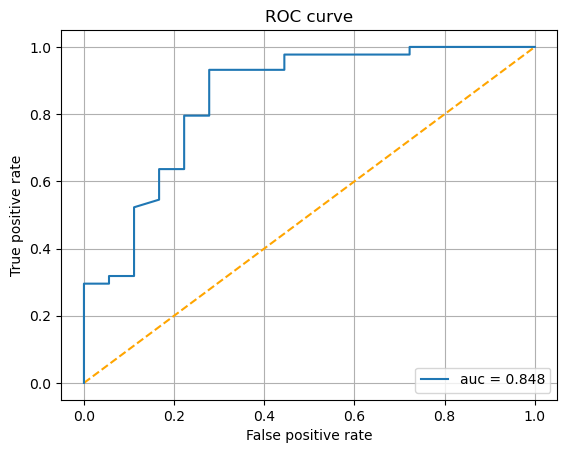

In [87]:
#Plotting a ROC/(AUC) for Random Forest
plotRoc(dt_test, best_rf)

ROC/AUC is 0.848 and it shows this model is relatively good predicting the outcome. Let's look at the confusion matrix.

In [93]:
## to create a confusion matrix for Random Forest

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_df = rfpredictions1.select('label', 'prediction').toPandas()

confusion = confusion_matrix(y_df.label,  y_df.prediction)
print(confusion)


print(classification_report(y_df.label, y_df.prediction))

[[41  3]
 [ 8 10]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        44
           1       0.77      0.56      0.65        18

    accuracy                           0.82        62
   macro avg       0.80      0.74      0.76        62
weighted avg       0.82      0.82      0.81        62



Let's look at which variable is the most importance in the model and causing the most threatening to heart failure.

In [89]:
import pandas as pd
featureImportance1 = pd.DataFrame(data = best_rf.featureImportances.toArray(), index = colms, columns=["Importance"])

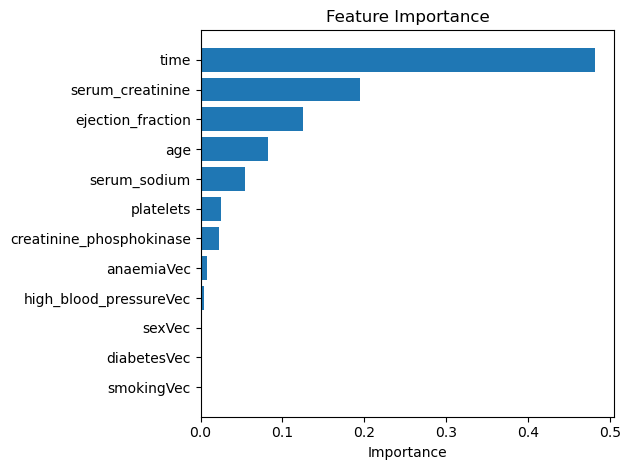

In [90]:
featureImportanceTop12a = featureImportance1.nlargest(12, 'Importance') ## we have only 12 variables

fig, ax = plt.subplots()
ax.barh(range(12), featureImportanceTop12a.Importance, )
ax.set_yticks(range(12))
ax.set_yticklabels(featureImportanceTop12a.index)
ax.set_xlabel('Importance')
ax.set_title('Feature Importance')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

Random Forest algorithm predicts that time (follow-up period) was the most important variable and other four variables (serum_creatinine, ejection_fraction, age, and serum_sodium) were also important variables predicting the event of death from heart failure.

# **6**. **Conclusion** #

The further process would be model deployment.